---
# iWildCam 2022 - FGVC9

##### Count the number of animals in a sequence of images
---

### **Objective**
Camera Traps enable the automatic collection of large quantities of image data. Ecologists all over the world use camera traps to monitor biodiversity and population density of animal species. In order to estimate the abundance (how many there are) and population density of species in camera trap data, ecologists need to know not just which species were seen, but also how many of each species were seen. However, because images are taken in motion-triggered bursts to increase the likelihood of capturing the animal(s) of interest, object detection alone is not sufficient as it could lead to over- or under-counting. For example, if you get 3 images taken at one frame per second, and in the first you see 3 gazelles, in the second you see 5 gazelles, and in the last you see 4 gazelles, how many total gazelles have you seen? This is more challenging than strictly detecting and categorizing species, as it requires reasoning and tracking of individuals across sparse temporal samples. For example, in the below sequence of images there are 6 baboons.


 <img alt="iwild" src="https://github.com/visipedia/iwildcam_comp/blob/master/assets/monkey_count.png?raw=true" width="850px"/>

Check out a few hard examples from the training set:

 <img alt="iwildcam" src="https://github.com/visipedia/iwildcam_comp/blob/master/assets/train_examples_smaller.gif?raw=true
" width="550px"/>


**This [iWildCam competition](https://www.kaggle.com/competitions/iwildcam2022-fgvc9/overview) will focus entirely on counting animals. We have prepared a challenge where the training data and test data are from different cameras spread across the globe. The set of species seen in each camera overlap, but are not identical. The challenge is to count individual animals across sequences in the test cameras.**

In this notebook, I provide an overview of the competition and explore the dataset before training a baseline model. Additionally, I conduct further analysis using the trained model. I present **two potential solutions: maximum detections in sequence and using the Object-Tracker-Model.** Finally, I draw some conclusions.



### **Data**

 [The iWildCam 2022 WCS](https://www.kaggle.com/competitions/iwildcam2022-fgvc9/data) training set contains 201,399 images from 323 locations, and the WCS test set contains 60,029 images from 91 locations. These 414 locations are spread across the globe. A location ID (location) is given for each image, and in some special cases where two cameras were set up by ecologists at the same location, we have provided a sub_location identifier. Camera traps operate with a motion trigger and, after motion is detected, the camera will take a sequence of photos (from 1 to 10 images depending on the camera). We provide a seq_id for each sequence, and your task is to count the number of individuals across each test sequence.

This year we are also providing count annotations on 1780 of the 36,292 train sequences (check the metadata/train_sequence_counts.csv file). We hope you will find them useful in building better models. We do not provide any count annotations for the test set.

---
### Table of Contents

1. Importing the required libraries
       
2. Load metadata information

3. Show Data

4. Possible solutions

       i) Solution 1: Maximum detections in sequence
                      Results
       ii) Solution 2: using Object-Tracker-Model
                       Results

5. Conclusion

---



## 1. Importing the required libraries

This script is importing necessary libraries and dependencies to train a model for object detection using TensorFlow.

- **argparse** is used for command-line argument parsing.
- **glob** is used to search for files or directories that match a specified pattern.
- **os** provides a way of interacting with the operating system.
- **sys** provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- **time** provides various time-related functions.
- **warnings** is used for warning control.
- **json** is used for working with JSON data.
- **codecs** is used for encoding and decoding Unicode data.
- **random** is used for generating random numbers.
- **scipy.optimize.linear_sum_assignment** solves the linear sum assignment problem.
- **math** provides mathematical functions defined by the C standard.



- **cycler** provides cycling and color schemes for Matplotlib.
- **matplotlib.pyplot** is a plotting library used for creating static, animated, and interactive visualizations in Python.
- **matplotlib.colors** provides a range of color maps and specifications.
- **matplotlib.patches** provides various kinds of patches for use in Matplotlib.
- **tensorflow** is a free and open-source software library for dataflow and differentiable programming across a range of tasks.
- **numpy** is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- **pandas** is a software library for data manipulation and analysis.



- **PIL** is the Python Imaging Library, which adds support for opening, manipulating, and saving many different image file formats.
- **statistics** is a module that provides functions for calculating mathematical statistics of numeric data.
- **torch.utils.data.Dataset** is an abstract class representing a dataset.
- **torch.utils.data.DataLoader** combines a dataset and a sampler, and provides an iterator over the dataset.
- **torch** is an open-source machine learning library based on the Torch library.
- **tqdm** is a fast and extensible progress bar for Python and CLI.


Finally, the script prints the TensorFlow version and whether a GPU is available or not.

In [1]:
#import required packages
import argparse
import glob
import os
import sys
print(sys.executable)
import time
import warnings
import json, codecs
import random
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment as linear_assignment
import math
import cycler
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

# import humanfriendly
import numpy as np
import pandas as pd
from PIL import Image, ImageFile, ImageFont, ImageDraw
import statistics
from torch.utils.data import Dataset,DataLoader
import torch

# import tensorflow.compat.v1 as tf 
# tf.disable_v2_behavior()
from tqdm import tqdm
%matplotlib inline

# from CameraTraps.ct_utils import truncate_float
print('TensorFlow version:', tf.__version__)
print('Is GPU available? tf.test.is_gpu_available:', tf.test.is_gpu_available())

/opt/conda/bin/python
TensorFlow version: 2.11.0
Is GPU available? tf.test.is_gpu_available: True


## 2. Load metadata information

In [2]:
# These are utility functions used for data preprocessing in the context of an object detection task. Here is a brief explanation of each function:

# image_name_to_id: This function takes an image name as input and returns its ID by removing the '.jpg' extension. 
# This is used to match the image with its corresponding annotations.
def image_name_to_id(name):
    return name.rstrip('.jpg')

# This function takes an image path as input and returns the image as a numpy array. 
# It opens the image using the Python Imaging Library (PIL).

def read_image(path):
    with tf.io.gfile.GFile(path, 'rb') as f:
        return np.array(Image.open(f))
    
# This function takes a path to a JSON file as input and returns the contents of the file as a Python dictionary. 
# It uses the 'tf.io.gfile.GFile' method to open the file.    

def read_json(path):
    with tf.io.gfile.GFile(path) as f:
        return json.load(f)
    
# This function takes the annotations and a mode as input and returns a dictionary mapping image IDs to their respective detections. 
# The mode is used to distinguish between train and test images. The annotations dictionary contains information about images, annotations, and categories. 
# This function iterates through the images and their corresponding detections and maps them to their respective IDs.    

def create_detection_map(annotations,mode="train"):
    """Creates a dict mapping IDs ---> detections."""
    ann_map = {}
    for image in annotations['images']:
        if image['file'].split('/')[0] == mode:
            ann_map[image['file'].split('/')[-1].rstrip('.jpg')] = image['detections']
    return ann_map

# TRAIN
# This code initializes variables with paths to directories and annotation files for train and test data. 
IMAGES_DIR_TRAIN = "/kaggle/input/iwildcam2022-fgvc9/train/train"
BOX_ANNOTATION_FILE = "/kaggle/input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_mdv4_detections.json"
MASKS_DIR = "/kaggle/input/iwildcam2022-fgvc9/instance_masks/instance_masks"

# It then loads the images in the train and test directories using tf.io.gfile.listdir.
images_train = tf.io.gfile.listdir(IMAGES_DIR_TRAIN)

# The annotations file contains annotations for all images in train and test
# The annotations variable is loaded using read_json function, which reads a JSON file containing annotations for all images in the train and test datasets. 
# detection_train_map and detection_test_map are created using the create_detection_map function which maps image IDs to their respective detections.
annotations = read_json(BOX_ANNOTATION_FILE)
detection_train_map = create_detection_map(annotations)
images_train_ids = list(detection_train_map.keys())

#TEST
IMAGES_DIR_TEST = "/kaggle/input/iwildcam2022-fgvc9/test/test"
images_test = tf.io.gfile.listdir(IMAGES_DIR_TEST)
detection_test_map = create_detection_map(annotations,mode="test")
images_test_ids = list(detection_test_map.keys())

# The code then prints the length of detection_train_map, detection_test_map, images_train, images_test, and annotations["images"].
print(f'length of detection map for train = {len(detection_train_map)}\nlength of detection map for test = {len(detection_test_map)}\n')
print(f'length of images for train = {len(images_train)}\nlength of images for test = {len(images_test)}\n')
print(f'total annotations from megaDetector model = {len(annotations["images"])}')

length of detection map for train = 201399
length of detection map for test = 60029

length of images for train = 201399
length of images for test = 60029

total annotations from megaDetector model = 261428


In [3]:
# This code reads the train and test metadata files as JSON objects using the json.load function. 
# The train and test metadata files contain information about images such as location, time, and weather conditions.

with codecs.open("../input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_train_annotations.json", 'r',
                 encoding='utf-8', errors='ignore') as f:
    train_meta = json.load(f)

# The seq_test and seq_train dataframes are then created using the pd.DataFrame function with the 'images' key of the respective metadata files as input. 
# The dataframes are then displayed using the display function.    
with codecs.open("../input/iwildcam2022-fgvc9/metadata/metadata/iwildcam2022_test_information.json", 'r',
                 encoding='utf-8', errors='ignore') as f:
    test_meta = json.load(f)
seq_test = pd.DataFrame(test_meta['images'])

#train_cat.columns = [ 'category_id', 'scientificName','family', 'genus']
display(seq_test)
seq_train = pd.DataFrame(train_meta['images'])
#train_cat.columns = [ 'category_id', 'scientificName','family', 'genus']
display(seq_train)

height                                    id  \
0        1024  8b31d3be-21bc-11ea-a13a-137349068a90   
1        1024  8cf202be-21bc-11ea-a13a-137349068a90   
2        1024  8a87e62e-21bc-11ea-a13a-137349068a90   
3        1024  8e6994f4-21bc-11ea-a13a-137349068a90   
4        1024  948b29e2-21bc-11ea-a13a-137349068a90   
...       ...                                   ...   
60024    1024  981aabf0-21bc-11ea-a13a-137349068a90   
60025    1024  971d8466-21bc-11ea-a13a-137349068a90   
60026    1024  90f05d20-21bc-11ea-a13a-137349068a90   
60027    1024  903c3ebc-21bc-11ea-a13a-137349068a90   
60028    1024  96e04790-21bc-11ea-a13a-137349068a90   

                                     seq_id  location  width  \
0      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
1      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
2      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
3      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
4      a91ebc18-0cd3-11eb-bed1-0242ac1c0002        20   1280   
...                                     ...       ...    ...   
60024  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60025  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60026  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60027  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   
60028  a91b0b90-0cd3-11eb-bed1-0242ac1c0002         5   1280   

                      datetime                                 file_name  \
0      2013-06-09 16:01:38.000  8b31d3be-21bc-11ea-a13a-137349068a90.jpg   
1      2013-06-09 16:01:39.000  8cf202be-21bc-11ea-a13a-137349068a90.jpg   
2      2013-06-09 16:01:40.000  8a87e62e-21bc-11ea-a13a-137349068a90.jpg   
3      2013-06-09 16:01:41.000  8e6994f4-21bc-11ea-a13a-137349068a90.jpg   
4      2013-06-09 16:01:42.000  948b29e2-21bc-11ea-a13a-137349068a90.jpg   
...                        ...                                       ...   
60024  2013-04-23 00:38:35.000  981aabf0-21bc-11ea-a13a-137349068a90.jpg   
60025  2013-04-23 00:38:36.000  971d8466-21bc-11ea-a13a-137349068a90.jpg   
60026  2013-04-23 00:38:37.000  90f05d20-21bc-11ea-a13a-137349068a90.jpg   
60027  2013-04-23 00:38:37.000  903c3ebc-21bc-11ea-a13a-137349068a90.jpg   
60028  2013-04-23 00:38:38.000  96e04790-21bc-11ea-a13a-137349068a90.jpg   

       seq_frame_num  seq_num_frames  sub_location  
0                  0              10           NaN  
1                  1              10           NaN  
2                  2              10           NaN  
3                  3              10           NaN  
4                  4              10           NaN  
...              ...             ...           ...  
60024              0               5           1.0  
60025              1               5           1.0  
60026              2               5           1.0  
60027              3               5           1.0  
60028              4               5           1.0  

[60029 rows x 10 columns]

seq_num_frames  location                 datetime  \
0                    6         3  2013-06-05 05:44:19.000   
1                    6         3  2013-06-05 05:44:20.000   
2                    6         3  2013-06-05 05:44:21.000   
3                    6         3  2013-06-05 05:44:22.000   
4                    6         3  2013-06-05 05:44:23.000   
...                ...       ...                      ...   
201394               6       165  2013-06-05 13:08:12.000   
201395               6       165  2013-06-05 13:08:19.000   
201396               6       165  2013-06-05 13:08:42.000   
201397               6       165  2013-06-05 13:08:48.000   
201398               6       165  2013-06-05 13:08:55.000   

                                          id  \
0       8b02698a-21bc-11ea-a13a-137349068a90   
1       8e5b81de-21bc-11ea-a13a-137349068a90   
2       8c6be0e4-21bc-11ea-a13a-137349068a90   
3       8fdf7998-21bc-11ea-a13a-137349068a90   
4       96093c50-21bc-11ea-a13a-137349068a90   
...                                      ...   
201394  91421eee-21bc-11ea-a13a-137349068a90   
201395  91140194-21bc-11ea-a13a-137349068a90   
201396  8f1f5f46-21bc-11ea-a13a-137349068a90   
201397  974a365a-21bc-11ea-a13a-137349068a90   
201398  93a4d938-21bc-11ea-a13a-137349068a90   

                                      seq_id  width  height  \
0       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
1       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
2       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
3       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
4       30048d32-7d42-11eb-8fb5-0242ac1c0002   1920    1080   
...                                      ...    ...     ...   
201394  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201395  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201396  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201397  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   
201398  974a375e-21bc-11ea-a13a-137349068a90   2048    1536   

                                       file_name  sub_location  seq_frame_num  
0       8b02698a-21bc-11ea-a13a-137349068a90.jpg           0.0              0  
1       8e5b81de-21bc-11ea-a13a-137349068a90.jpg           0.0              1  
2       8c6be0e4-21bc-11ea-a13a-137349068a90.jpg           0.0              2  
3       8fdf7998-21bc-11ea-a13a-137349068a90.jpg           0.0              3  
4       96093c50-21bc-11ea-a13a-137349068a90.jpg           0.0              4  
...                                          ...           ...            ...  
201394  91421eee-21bc-11ea-a13a-137349068a90.jpg           NaN              1  
201395  91140194-21bc-11ea-a13a-137349068a90.jpg           NaN              2  
201396  8f1f5f46-21bc-11ea-a13a-137349068a90.jpg           NaN              3  
201397  974a365a-21bc-11ea-a13a-137349068a90.jpg           NaN              4  
201398  93a4d938-21bc-11ea-a13a-137349068a90.jpg           NaN              5  

[201399 rows x 10 columns]

## 3. Show Data

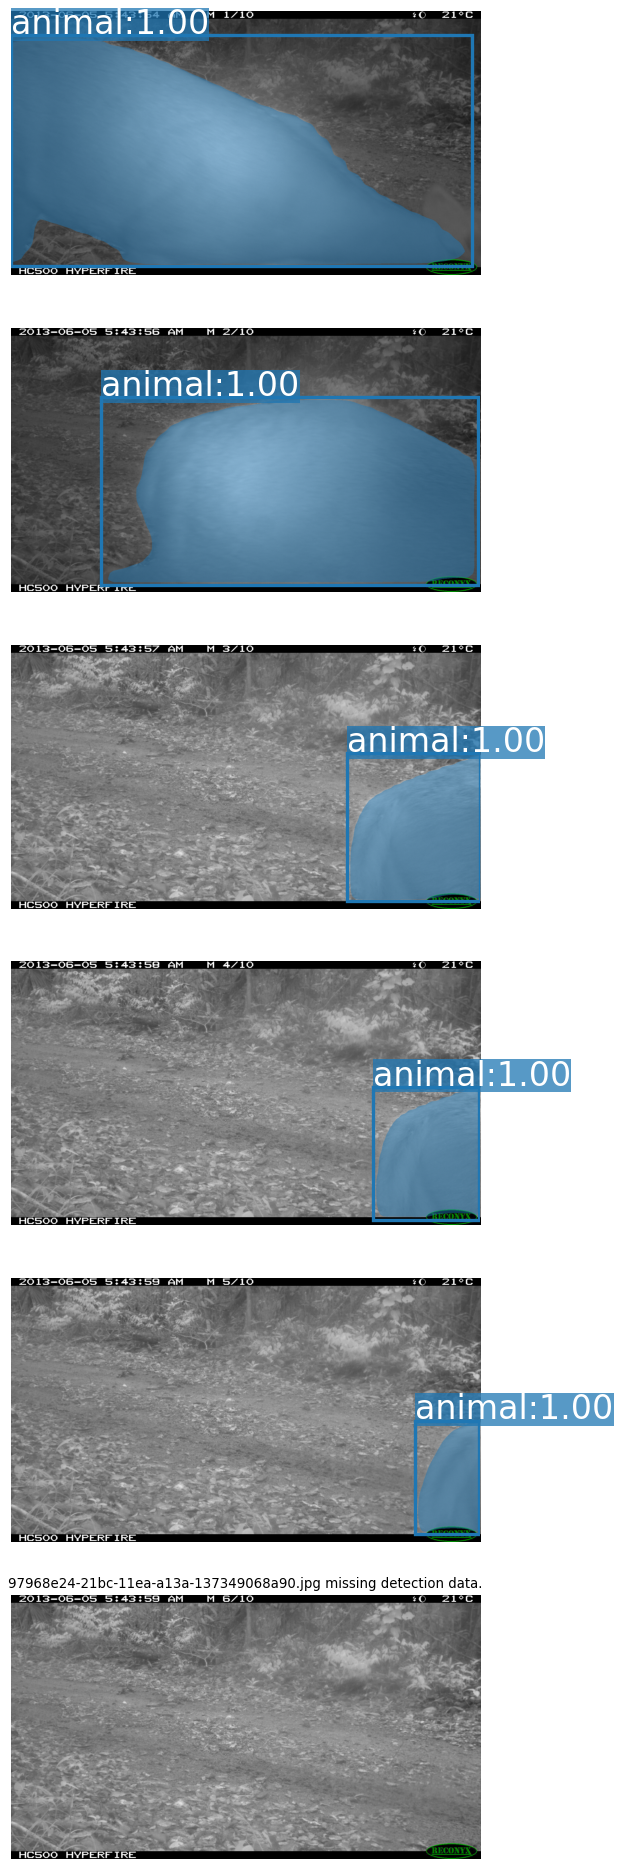

In [4]:
# This code defines a function named get_image_annotation() that takes in an image, a list of detection annotations, a dictionary mapping category IDs to names, an instance ID image, and an axis object ax for plotting. 
# The function then plots bounding boxes and mask annotations for the given image using the detection annotations and instance ID image.

COLOR_CYCLER = cycler.cycler(color=['tab:blue', 'tab:green', 'tab:orange',
                                    'tab:red', 'tab:purple'])
pd_example = seq_train[seq_train['seq_id'] == "30048d32-7d42-11eb-8fb5-0242ac1c0002"]
def  get_image_annotation(image, detection_annotations, categories,instance_id_image,ax):
    """Plot boxes and mask annotations for a given image.

            Args:
            image: An image array of shape [H, W, 3]
            detection_annotations: A list of detections. Each detection is a dict
              containing the keys 'category', 'bbox' and 'conf'.
            categories: A dict mapping category IDs to names.
            instance_id_image: An array of shape [H, W] containing the instance ID
              at each pixel. IDs are expected to be 1-indexed, with 0 reserved for
              the background."""

    
    # The function uses a color cycler COLOR_CYCLER to assign colors to the bounding boxes and mask annotations. 
    # The color cycler cycles through a list of five colors defined by the cycler module. 
    cycle_iter = COLOR_CYCLER()
    image_height, image_width = image.shape[:2]
    ax.imshow(image)
    # The function iterates through each annotation in the list of detection annotations and extracts the bounding box coordinates, category, confidence score, and instance ID. 
    for i, annotation in enumerate(detection_annotations):
        xmin, ymin, width, height = annotation['bbox']
        xmin *= image_width
        ymin *= image_height
        width *= image_width
        height *= image_height
        color = next(cycle_iter)['color']
        # It then plots a rectangle using the bounding box coordinates and assigns a label to the rectangle containing the category name and confidence score. 
        # The label is placed below the rectangle using the ax.text() method.
        rect = patches.Rectangle((xmin, ymin), width, height,
                                 linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        label = '{}:{:.2f}'.format(categories[annotation['category']],
                                   annotation['conf'])

        # The function also creates a color mask for each annotation using the instance ID image and the color assigned by the color cycler. 
        ax.text(xmin, ymin - 5, label, fontsize=30, color='white',
                  bbox=dict(boxstyle='square,pad=0.0', facecolor=color, alpha=0.75,
                            ec='none'))
        # The color mask is an RGB image where each pixel in the annotation's mask is assigned the same color as the bounding box. 
        r, g, b, _ = colors.to_rgba(color)
        color_array = np.array([r, g, b]).reshape(1, 1, 3)
        color_image = np.ones((image_height, image_width, 3)) * color_array
        mask = (instance_id_image == (i + 1)).astype(np.float32)[:, :, np.newaxis]
        color_mask = np.concatenate([color_image, mask], axis=2)
        # The color mask is then plotted on top of the original image using the ax.imshow() method with an alpha value of 0.5. Finally, the function returns the last color mask plotted.
        ax.imshow(color_mask, alpha=0.5)
    return color_mask


# This function show_images_seq takes in a pandas DataFrame data, a dictionary detections containing detection 
# data for each image, and a boolean flag train indicating whether the images are from the training set or the test set.
def show_images_seq(data,detections,train = True):
    rows = data.shape[0]
    cols = data.shape[1]
    # The function first sets the number of rows and columns to be equal to the number of rows in the data DataFrame. 
    # It then creates a figure with subplots using subplots method of matplotlib.pyplot. 
    # The number of rows is used to determine the figure size.
    fig, axs = plt.subplots(rows, dpi=80,  figsize=(rows*5, rows*5))
    for i in range(rows):
        image_name = data["file_name"][i]
        image_path = os.path.join(IMAGES_DIR_TRAIN if train else IMAGES_DIR_TEST, image_name)
        image_id = image_name_to_id(image_name)
        mask_path = os.path.join(MASKS_DIR, f'{image_id}.png')
        image = read_image(image_path)
        # Next, for each row in the data DataFrame, the function checks if detection data is available for the corresponding image. If not, it displays a message indicating that the detection data is missing and displays the image using imshow method of matplotlib.pyplot. 
        # Otherwise, it reads the mask image corresponding to the image using the read_image function and displays both the image and the mask with annotations using the get_image_annotation function.
        if (image_id not in detections) or (len(detections[image_id]) == 0) or ( not tf.io.gfile.exists(mask_path)):
            plt.title(f'{image_name} missing detection data.')
            axs[i].imshow(image)
        else:
            detection_annotations = detections[image_id]
            instance_id_image = read_image(mask_path)
            image = get_image_annotation(image,detection_annotations,annotations['detection_categories'],instance_id_image,axs[i])   
            
        axs[i].axis("off")    
    plt.show()
# Finally, the function turns off the axis of the plot using axis("off") method of matplotlib.pyplot and displays the plot using show method of matplotlib.pyplot.            
show_images_seq(pd_example,detection_train_map)

## 4. Possible solutions include:
* Solution 1: Iwildcam competition winners in 2021 counted the maximum number of bboxes per frame as part of their sequence.
* Solution 2. The identified objects will be tracked using an object tracker, which gives each object a unique ID number.

### Solution 1: Maximum detections in sequence

Maximum detections in sequence refers to the **maximum number of bounding box annotations (detections)** that are present in a single frame of a given sequence. In the context of the iWildCam 2021 competition, the maximum detections in sequence were used as a metric to evaluate the performance of the participants' models in detecting and localizing animals in camera trap images. The winners of the competition were able to achieve high accuracy in predicting the presence of animals in the images while also keeping the number of false positives and false negatives low, even when the images contained a large number of animals or other objects of interest.

In [5]:
# The count_detections function takes a row from the metadata DataFrame and a dictionary of detections as input. 
# It first extracts the image ID from the row, and then iterates over the list of detections for that image in the dictionary. 
# For each detection, if the confidence score of the detection is above a certain threshold (0.8 in this case), the count of detections is incremented. 
# The function returns the final count of detections for the given image.
def count_detections(row,detections):
    image_id = row['file_name'].split('.')[0]
    threshold = 0.8
    count = 0
    
    for bbox in detections[image_id]:
        if bbox['conf'] > threshold:
            count += 1   
    return count

# The generate_zero_submission function takes a list of sequence IDs as input and generates a submission DataFrame with these IDs and a prediction of 0 for each sequence. 
# The resulting DataFrame has two columns: 'Id' and 'Predicted'.
def generate_zero_submission(seq_ids):
    sub = pd.DataFrame(seq_ids, columns=['Id'])
    sub['Predicted'] = 0
    return sub

In [6]:
# This code block computes the number of animal detections in each sequence of the test set using the count_detections() function. 
# Then, it generates a submission file containing the maximum number of detections for each sequence.
seq_test["detections_count"] = np.nan
for idx,row in tqdm(seq_test.iterrows()):
    # The seq_test dataframe is iterated over and for each row, the count_detections() function is called with the detections map of the test set to count the number of animal detections in the corresponding sequence. 
    # The resulting count is then stored in the detections_count column of seq_test.
    seq_test.at[idx, 'detections_count'] = count_detections(row,detection_test_map)

# A new dataframe named submission_res_by_max is created with the sequence IDs of the test set as the Id column and all Predicted values initialized to zero using the generate_zero_submission() function.
submission_res_by_max = generate_zero_submission(seq_test.seq_id.unique())
# Then, for each unique sequence ID, the maximum number of detections in that sequence is computed and stored in the submission_res_by_max dataframe.
for seq_id in tqdm(seq_test.seq_id.unique()):
    max_count = seq_test[seq_test.seq_id == seq_id]['detections_count'].max()
    submission_res_by_max.loc[submission_res_by_max.Id == seq_id, 'Predicted'] = max_count

# Finally, the submission_res_by_max dataframe is displayed, and its Predicted column is saved to a CSV file named "res_by_max.csv". 
# The maximum value in the Predicted column is printed to the console.
display(submission_res_by_max)
print(max(submission_res_by_max.Predicted))
submission_res_by_max.to_csv (r'res_by_max.csv', index = False, header=True) 


60029it [00:03, 15595.51it/s]
100%|██████████| 11028/11028 [01:08<00:00, 159.93it/s]


Id  Predicted
0      a91ebc18-0cd3-11eb-bed1-0242ac1c0002          1
1      a91d6764-0cd3-11eb-bed1-0242ac1c0002          1
2      91ccb676-21bc-11ea-a13a-137349068a90          0
3      386914ce-6fe2-11eb-844f-0242ac1c0002          0
4      988ae29e-21bc-11ea-a13a-137349068a90          0
...                                     ...        ...
11023  a918faee-0cd3-11eb-bed1-0242ac1c0002          1
11024  94284f52-21bc-11ea-a13a-137349068a90          0
11025  9912f080-21bc-11ea-a13a-137349068a90          0
11026  96fe10f4-21bc-11ea-a13a-137349068a90          0
11027  a91b0b90-0cd3-11eb-bed1-0242ac1c0002          1

[11028 rows x 2 columns]

13


### Results: 
* My result on leaderboard (0.494) is the result of a random solution.
* Maximum number of detections in each sequence according to conf> 0.85  
    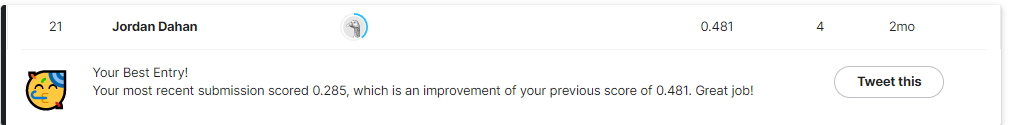    
* Maximum number of detections in each sequence according to conf> 0.9  
    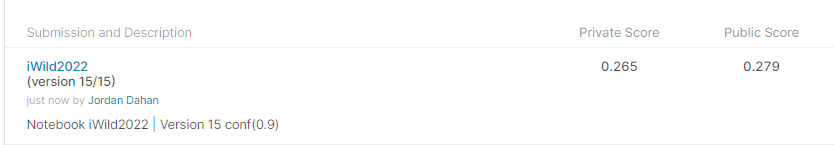
* Maximum number of detections in each sequence according to conf> 0.95  
    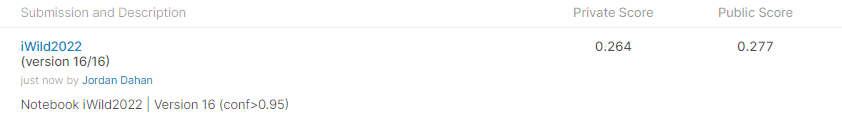
* Maximum number of detections in each sequence according to conf> 0.97   
    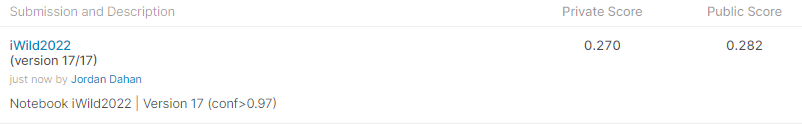


* As you can see - when the solution is to count the number of maximum detections of the megadetector model, the best results come when extracting the detections with conf> 0.95



### Solution 2: using Object-Tracker-Model


### Introduction to Tracking
Tracking in deep learning is the task of predicting the positions of objects throughout a video using their spatial as well as temporal features. More technically, Tracking is getting the initial set of detections, assigning unique ids, and tracking them throughout frames of the video (or sequence of frames) feed while maintaining the assigned ids. Tracking is generally a two-step process:  
    **1. A detection module for target localization: The module responsible for detecting and localization of the object in the frame using some object detector like YOLOv4, CenterNet, etc (In our case- the detections is given part of db).**  
    **2. A motion predictor: This module is responsible for predicting the future motion of the object using its past information.**

### Types of Trackers

1. **Single Object Tracker**- These types of trackers track only a single object even if there are many other objects present in the frame. (We will not use here).
2. **Multiple Object Tracker -**
These types of trackers can track multiple objects present in a frame. Some of the algorithms include DeepSORT, JDE, and CenterTrack which are very powerful algorithms and handle most of the challenges faced by trackers. (We will present the idea below).  

DeepSORT: [arXiv:1703.07402](https://arxiv.org/abs/1703.07402)  
Centroid: [centroid tracking](https://pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/)


### Centroid-Tracker

  0%|          | 16/11028 [00:00<01:09, 159.35it/s]

height                                    id  \
0    1536  9773fd0a-21bc-11ea-a13a-137349068a90   
1    1536  905518c4-21bc-11ea-a13a-137349068a90   
2    1536  952100c0-21bc-11ea-a13a-137349068a90   
3    1536  87a353e4-21bc-11ea-a13a-137349068a90   
4    1536  9557f666-21bc-11ea-a13a-137349068a90   
5    1536  9800e47c-21bc-11ea-a13a-137349068a90   
6    1536  92b2b27a-21bc-11ea-a13a-137349068a90   
7    1536  97adf12c-21bc-11ea-a13a-137349068a90   
8    1536  8e3a8e66-21bc-11ea-a13a-137349068a90   
9    1536  964d7fdc-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  \
0  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
1  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
2  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
3  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
4  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
5  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
6  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
7  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
8  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   
9  a9187f88-0cd3-11eb-bed1-0242ac1c0002       507   2048   

                  datetime                                 file_name  \
0  2013-02-17 07:25:15.000  9773fd0a-21bc-11ea-a13a-137349068a90.jpg   
1  2013-02-17 07:25:21.000  905518c4-21bc-11ea-a13a-137349068a90.jpg   
2  2013-02-17 07:25:40.000  952100c0-21bc-11ea-a13a-137349068a90.jpg   
3  2013-02-17 07:25:47.000  87a353e4-21bc-11ea-a13a-137349068a90.jpg   
4  2013-02-17 07:25:53.000  9557f666-21bc-11ea-a13a-137349068a90.jpg   
5  2013-02-17 07:26:22.000  9800e47c-21bc-11ea-a13a-137349068a90.jpg   
6  2013-02-17 07:26:28.000  92b2b27a-21bc-11ea-a13a-137349068a90.jpg   
7  2013-02-17 07:26:35.000  97adf12c-21bc-11ea-a13a-137349068a90.jpg   
8  2013-02-17 07:26:53.000  8e3a8e66-21bc-11ea-a13a-137349068a90.jpg   
9  2013-02-17 07:27:00.000  964d7fdc-21bc-11ea-a13a-137349068a90.jpg   

   seq_frame_num  seq_num_frames  sub_location  detections_count  
0              0              10           NaN               0.0  
1              1              10           NaN               0.0  
2              2              10           NaN               1.0  
3              3              10           NaN               2.0  
4              4              10           NaN               2.0  
5              5              10           NaN               1.0  
6              6              10           NaN               1.0  
7              7              10           NaN               1.0  
8              8              10           NaN               2.0  
9              9              10           NaN               2.0

  0%|          | 16/11028 [00:16<01:09, 159.35it/s]

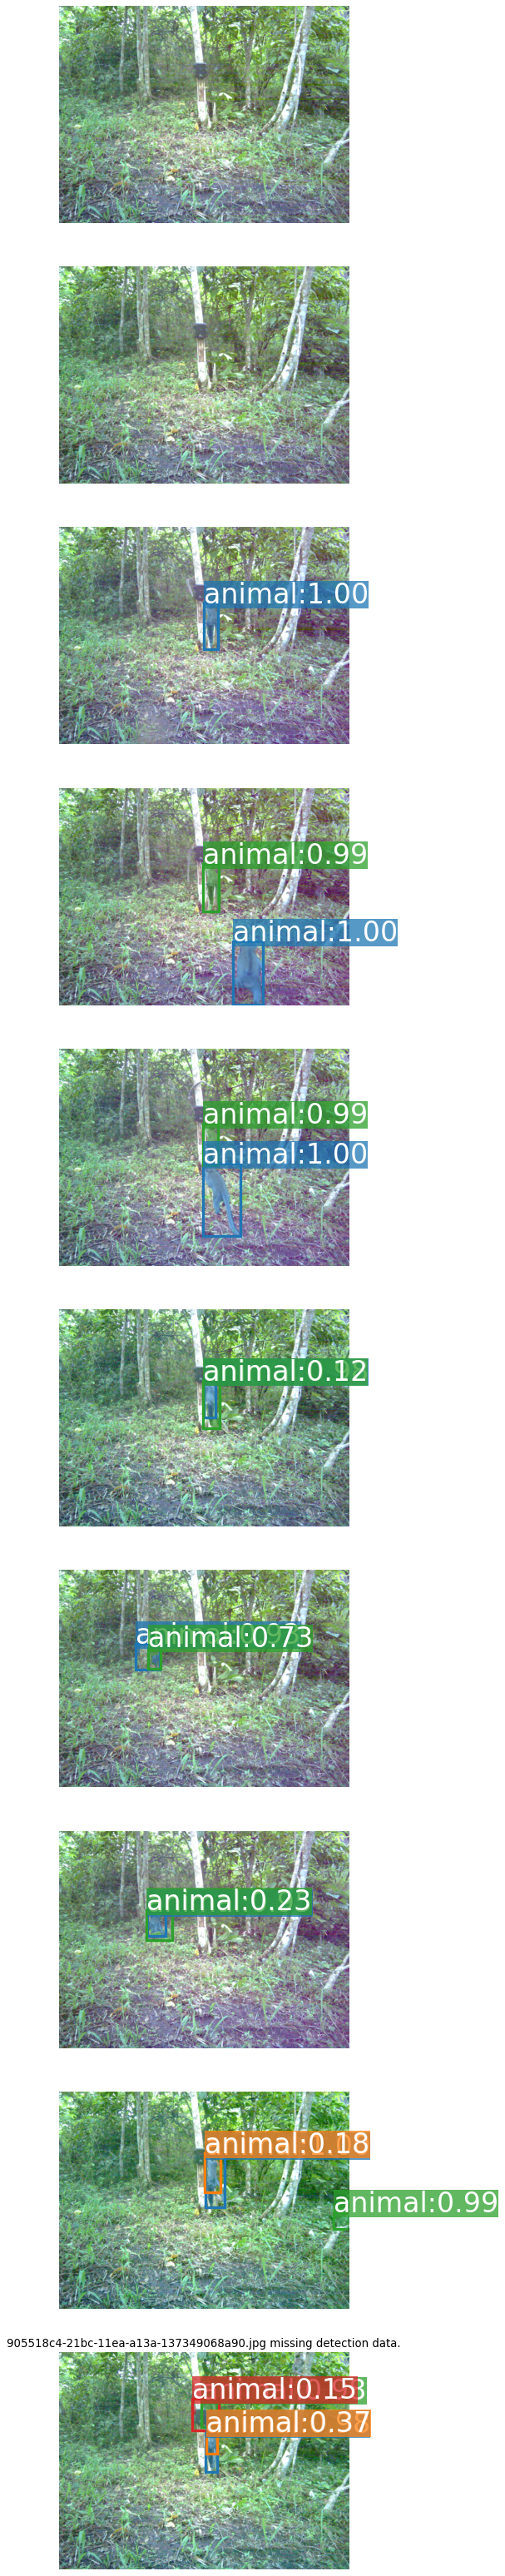

  0%|          | 28/11028 [00:17<2:15:34,  1.35it/s]

id_count = 2


height                                    id  \
0    1080  86e72872-21bc-11ea-a13a-137349068a90   
1    1080  878d5aee-21bc-11ea-a13a-137349068a90   
2    1080  8c5815a0-21bc-11ea-a13a-137349068a90   
3    1080  9266e106-21bc-11ea-a13a-137349068a90   
4    1080  8cc34848-21bc-11ea-a13a-137349068a90   
5    1080  8ce0cd28-21bc-11ea-a13a-137349068a90   
6    1080  889005e0-21bc-11ea-a13a-137349068a90   
7    1080  8aeb6a82-21bc-11ea-a13a-137349068a90   
8    1080  906ca250-21bc-11ea-a13a-137349068a90   
9    1080  98b6123e-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  \
0  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
1  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
2  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
3  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
4  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
5  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
6  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
7  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
8  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   
9  a917ba44-0cd3-11eb-bed1-0242ac1c0002       467   1920   

                  datetime                                 file_name  \
0  2013-01-19 09:31:31.000  86e72872-21bc-11ea-a13a-137349068a90.jpg   
1  2013-01-19 09:31:32.000  878d5aee-21bc-11ea-a13a-137349068a90.jpg   
2  2013-01-19 09:31:33.000  8c5815a0-21bc-11ea-a13a-137349068a90.jpg   
3  2013-01-19 09:31:41.000  9266e106-21bc-11ea-a13a-137349068a90.jpg   
4  2013-01-19 09:31:42.000  8cc34848-21bc-11ea-a13a-137349068a90.jpg   
5  2013-01-19 09:31:43.000  8ce0cd28-21bc-11ea-a13a-137349068a90.jpg   
6  2013-01-19 09:31:49.000  889005e0-21bc-11ea-a13a-137349068a90.jpg   
7  2013-01-19 09:31:50.000  8aeb6a82-21bc-11ea-a13a-137349068a90.jpg   
8  2013-01-19 09:31:51.000  906ca250-21bc-11ea-a13a-137349068a90.jpg   
9  2013-01-19 09:31:52.000  98b6123e-21bc-11ea-a13a-137349068a90.jpg   

   seq_frame_num  seq_num_frames  sub_location  detections_count  
0              0              10           NaN               1.0  
1              1              10           NaN               1.0  
2              2              10           NaN               1.0  
3              3              10           NaN               1.0  
4              4              10           NaN               0.0  
5              5              10           NaN               1.0  
6              6              10           NaN               1.0  
7              7              10           NaN               1.0  
8              8              10           NaN               1.0  
9              9              10           NaN               0.0

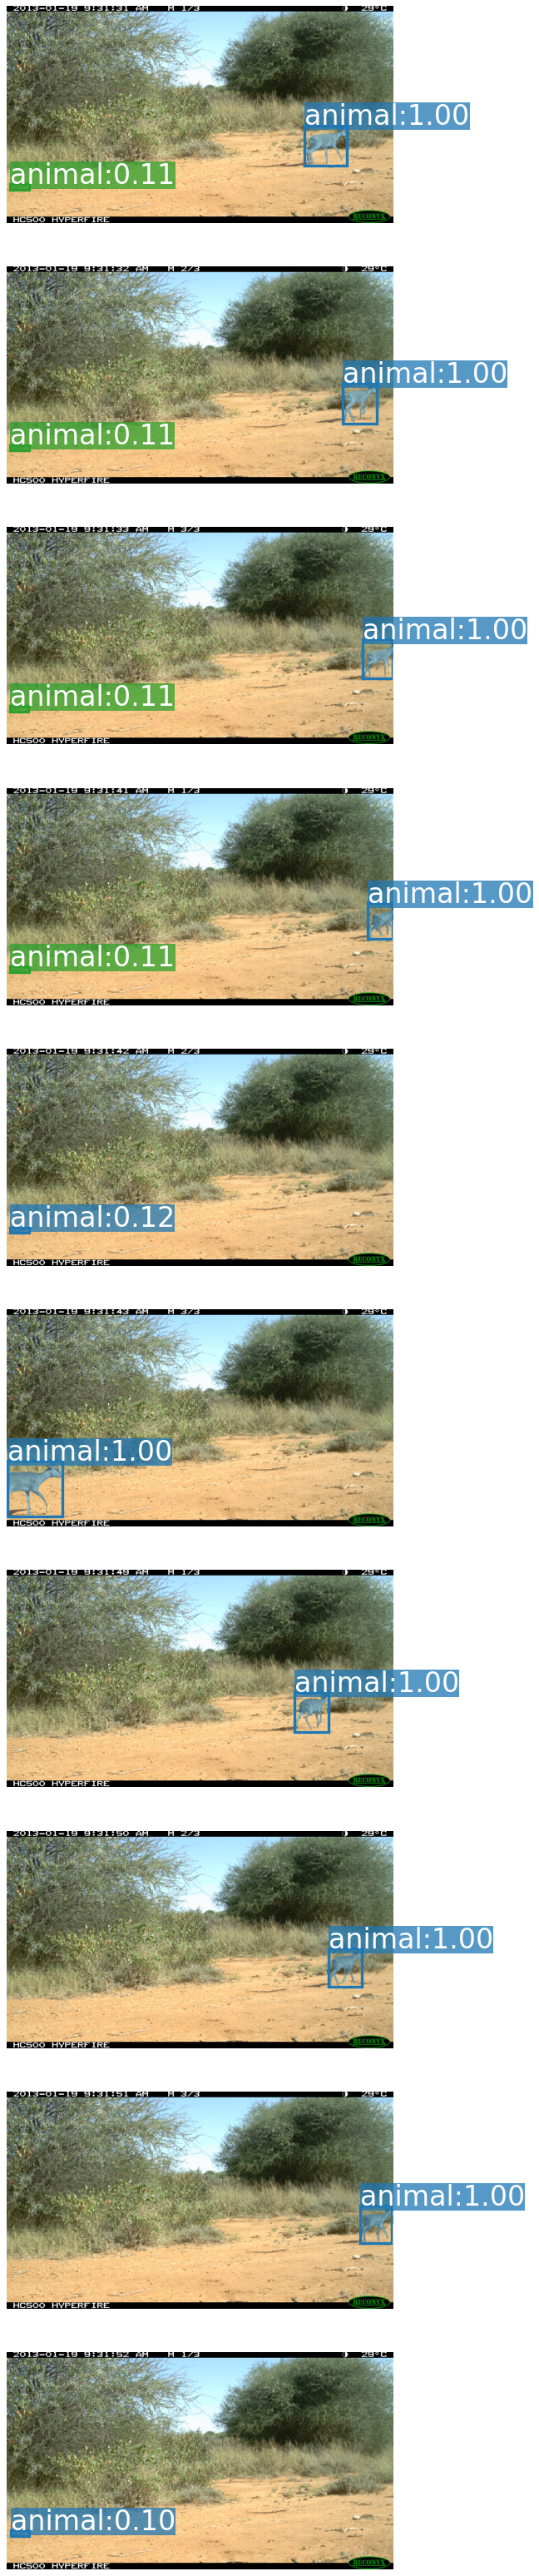

  0%|          | 50/11028 [00:28<1:35:35,  1.91it/s]

id_count = 2


height                                    id  \
0    1536  87d975be-21bc-11ea-a13a-137349068a90   
1    1536  8b81d422-21bc-11ea-a13a-137349068a90   
2    1536  8fd14e36-21bc-11ea-a13a-137349068a90   
3    1536  91ff45d2-21bc-11ea-a13a-137349068a90   
4    1536  867837f0-21bc-11ea-a13a-137349068a90   
5    1536  90ade954-21bc-11ea-a13a-137349068a90   
6    1536  8e69aade-21bc-11ea-a13a-137349068a90   
7    1536  971156be-21bc-11ea-a13a-137349068a90   
8    1536  967df13a-21bc-11ea-a13a-137349068a90   
9    1536  905ccbd2-21bc-11ea-a13a-137349068a90   

                                 seq_id  location  width  \
0  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
1  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
2  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
3  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
4  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
5  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
6  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
7  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
8  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   
9  a91a581c-0cd3-11eb-bed1-0242ac1c0002       292   2048   

                  datetime                                 file_name  \
0  2014-07-07 05:22:03.000  87d975be-21bc-11ea-a13a-137349068a90.jpg   
1  2014-07-07 05:22:03.000  8b81d422-21bc-11ea-a13a-137349068a90.jpg   
2  2014-07-07 05:22:03.000  8fd14e36-21bc-11ea-a13a-137349068a90.jpg   
3  2014-07-07 05:22:03.000  91ff45d2-21bc-11ea-a13a-137349068a90.jpg   
4  2014-07-07 05:22:03.000  867837f0-21bc-11ea-a13a-137349068a90.jpg   
5  2014-07-07 05:22:03.000  90ade954-21bc-11ea-a13a-137349068a90.jpg   
6  2014-07-07 05:22:04.000  8e69aade-21bc-11ea-a13a-137349068a90.jpg   
7  2014-07-07 05:22:04.000  971156be-21bc-11ea-a13a-137349068a90.jpg   
8  2014-07-07 05:22:04.000  967df13a-21bc-11ea-a13a-137349068a90.jpg   
9  2014-07-07 05:22:04.000  905ccbd2-21bc-11ea-a13a-137349068a90.jpg   

   seq_frame_num  seq_num_frames  sub_location  detections_count  
0              0              10           NaN               1.0  
1              1              10           NaN               1.0  
2              2              10           NaN               1.0  
3              3              10           NaN               1.0  
4              4              10           NaN               1.0  
5              5              10           NaN               1.0  
6              6              10           NaN               1.0  
7              7              10           NaN               1.0  
8              8              10           NaN               1.0  
9              9              10           NaN               1.0

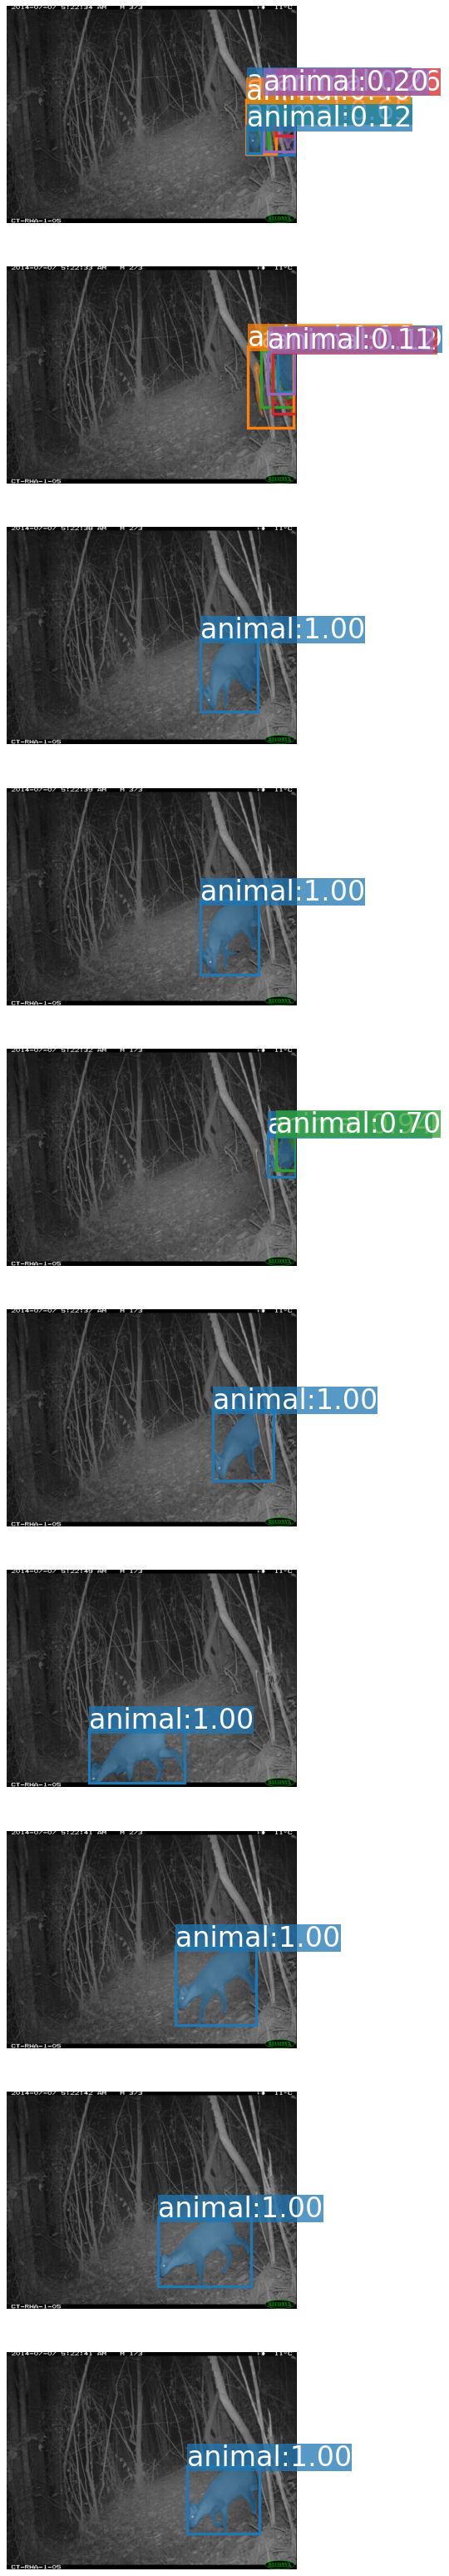

  1%|          | 78/11028 [00:46<1:40:11,  1.82it/s]

id_count = 3


100%|██████████| 11028/11028 [01:59<00:00, 92.08it/s] 


Id  Predicted
0      a91ebc18-0cd3-11eb-bed1-0242ac1c0002          1
1      a91d6764-0cd3-11eb-bed1-0242ac1c0002          1
2      91ccb676-21bc-11ea-a13a-137349068a90          0
3      386914ce-6fe2-11eb-844f-0242ac1c0002          0
4      988ae29e-21bc-11ea-a13a-137349068a90          0
...                                     ...        ...
11023  a918faee-0cd3-11eb-bed1-0242ac1c0002          1
11024  94284f52-21bc-11ea-a13a-137349068a90          0
11025  9912f080-21bc-11ea-a13a-137349068a90          0
11026  96fe10f4-21bc-11ea-a13a-137349068a90          0
11027  a91b0b90-0cd3-11eb-bed1-0242ac1c0002          1

[11028 rows x 2 columns]

4


In [7]:
# This is the beginning of a class called EuclideanDistTracker which is used for object tracking.
# The class has an initializer method __init__ that initializes two instance variables:
# self.center_points is a dictionary that stores the last known center point of each object being tracked, indexed by object ID.
# self.id_count is a counter for assigning a unique ID to each new object being tracked. 

class EuclideanDistTracker:
    def __init__(self):
        self.center_points = {}
        self.id_count = 0
    
    def update(self, objects_rect):
        """
        Parameters:
        -----------
        object_rect:  array of bounding box coordinates.
        --------
        Returns:
            list containing [x,y,w,h,object_id].
                x,y,w,h are the bounding box coordinates, and object_id is the id assigned to that particular bounding box.
        --------
        """
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx,cy = (x+w)/2, (y+h)/2
#             cx = (x + x + w) // 2 # Center x
#             cy = (y + y + h) // 2 # Center y
            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 25:
                    self.center_points[id] = (cx, cy)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

# This code is using an instance of the EuclideanDistTracker class to track animal detections across frames in a sequence. 
def get_detections(detections_dict,height,width):
    detections = []
    for diction in detections_dict:
        if diction['conf'] > 0.95:
            detections.append(diction['bbox'])

    return detections 
    
tracker = EuclideanDistTracker()
# Once the tracker is updated with the detections, it counts the number of unique IDs in the tracker and assigns this value to the corresponding sequence ID in submission_res_by_tracks.     
submission_res_by_tracks = generate_zero_submission(seq_test.seq_id.unique())
i=0
for seq_id in tqdm(seq_test.seq_id.unique()):
    tracker.__init__()
    seq_frames = seq_test[seq_test.seq_id == seq_id].sort_values(by=['seq_frame_num']).reset_index( drop = True)
    for _,frame in seq_frames.iterrows():
        # For each sequence in the test set, it retrieves the frame detections from detection_test_map and feeds them to the tracker. 
        detections = get_detections(detection_test_map[frame['id']], frame['height'],frame['width'])
        boxes_ids = tracker.update(detections)
    # The code also includes a conditional block that displays the frames and detections for the first three sequences in the test set if the tracker identifies more than one animal ID. 
    # This is useful for visual inspection and debugging.
    if i < 3 and tracker.id_count > 1 :
        display(seq_frames)
        show_images_seq(seq_frames,detection_test_map,train=False)
        print(f'id_count = {tracker.id_count}')
        i+=1
        submission_res_by_tracks.loc[submission_res_by_tracks.Id == seq_id, 'Predicted'] = tracker.id_count

# Finally, the results are saved to a CSV file.  
display(submission_res_by_tracks)
print(max(submission_res_by_tracks.Predicted))
submission_res_by_tracks.to_csv (r'res_by_tracks.csv', index = False, header=True) 


### Results: 
* As you remember, when the solution was the maximum number of consecutive identifications - the best result achieved:
    - Private = 0.264, Public = 0.277

Now with centroid-tracker model:
* with the limit of conf>0.95 on the detections:    
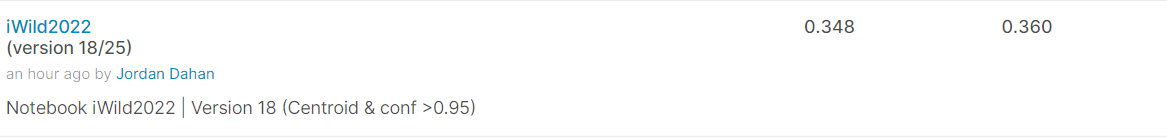  
    - Private = 0.348  Public = 0.360
* without the conf restriction on the detections:  
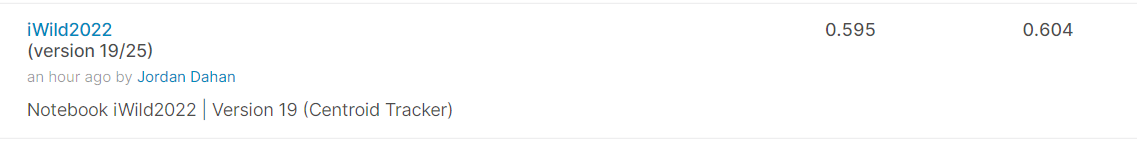
    - Private = 0.595 Public = 0.604


DEEP-SORT-TRACKER
https://pypi.org/project/deep-sort-realtime/

## Conclusion
* It is obvious that the performance of the object tracker is not as good as the counting heuristic. There could be several reasons for this.
- Also, in order to get better performance - we can produce the identifications ourselves by our own model.

    * It makes sense that the counting heuristic works best because we are counting animals in this project and since they were taken with a cameratrap (which takes many pictures in sequence when it detects movement) it could be that in one frame all the animals that passed by in sequence were captured. Therefore, the simple and working solution is to count the maximum number of identifications in the sequence of images.

* You can also try the deep sort tracker which uses a Kalman filter on the image sequences.
    * !git clone https://github.com/Jordan-me/DeepSort_Tracker.git
    * here is a code for start.

In [8]:
"""
This code taken from https://github.com/alcunha/iwildcam2021ufam
"""
!git clone https://github.com/Jordan-me/DeepSort_Tracker.git
from DeepSort_Tracker.deep_sort import nn_matching
from DeepSort_Tracker.deep_sort.detection import Detection
from DeepSort_Tracker.deep_sort.tracker import Tracker

# Finally, two global variables are defined - max_cosine_distance and nn_budget. max_cosine_distance is the maximum distance between feature vectors for a detection to be considered a match, and nn_budget is the maximum number of detections that the nearest-neighbor matching algorithm will consider when making a match.
max_cosine_distance = 0.2
nn_budget = None

def create_detections(annot, image_id):
    """
    This method return array of Detection objec (see class above)
    Parameters
    ----------
    annot : dataframe_like of bounding boxes for given images
    img_id : string desctibe image id  
    """
    detection_list = []
    for bbox in annot[image_id]:
        detection_list.append(Detection(bbox['bbox'],bbox['conf'],None))

    return detection_list

def run_deepsort_on_seq(detections_list, frames_ids):
    metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
    tracker = Tracker(metric)
    confirmed_tracks = []
    all_tracks = []

    for frame_id, detections in zip(frames_ids, detections_list):
        tracker.predict()
        for i in  detections:
            print(i.tlwh)
        tracker.update(detections)

    for track in tracker.tracks:
        if track.is_confirmed():
            confirmed_tracks.append(track.track_id)

        if track.time_since_update > 1:
            continue
        bbox = track.to_tlwh()
        all_tracks.append([frame_id, track.track_id, bbox[0], bbox[1], bbox[2], bbox[3]])
        
    confirmed_tracks = set(confirmed_tracks)
    print(confirmed_tracks)
    results = [track_bbox for track_bbox in all_tracks
             if track_bbox[1] in confirmed_tracks]
    print(results)
    return results

def track_iwildcam(data_set, annotations):
    tracks_list = []
    for seq_id in data_set.seq_id.unique():
        seq_info = data_set[data_set.seq_id == seq_id]
        seq_info = seq_info.sort_values(by=['seq_frame_num']) # [1st frame, 2st frame ,...]

        detections_list = []
        frames_ids = []
        for _, row in seq_info.iterrows():     # for each farme..
            detections = create_detections(annotations, row['id'])
            detections_list.append(detections)
            frames_ids.append(row['id'])

        results = run_deepsort_on_seq(detections_list, frames_ids)

    for bbox in results:
        bbox_info = {'seq_id': seq_id,
                     'img_id': bbox[0],
                     'track_id': seq_id + str(bbox[1]),
                     'bbox_tlwh': bbox[2:]      }
        tracks_list.append(bbox_info)
        
    return tracks_list

# confirmed_tracks = track_iwildcam(seq_test, detection_test_map)
# tracker = DeepSort(max_age=30, nn_budget=70, override_track_class=None)

Cloning into 'DeepSort_Tracker'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 145 (delta 81), reused 139 (delta 78), pack-reused 0
Receiving objects: 100% (145/145), 57.98 KiB | 3.62 MiB/s, done.
Resolving deltas: 100% (81/81), done.


This code block is cloning a GitHub repository containing the DeepSort Tracker implementation. DeepSort is a popular object tracking algorithm that combines a traditional object detector with a deep learning-based re-identification network to track objects over time.

The subsequent lines import various modules from the DeepSort library, including the nearest-neighbor matching module, the detection module, and the tracker module.

The overall this code is to implement object tracking using the DeepSORT (Deep Simple Online and Realtime Tracking) algorithm on a set of images or a video sequence. The code takes in a dataset and annotations of bounding boxes for objects in each image, creates detections from the annotations, and then applies the DeepSORT algorithm to track the objects across frames. The code outputs a list of tracks for each object in the dataset, including the sequence ID, image ID, track ID, and bounding box coordinates for each frame in which the object appears.


**Thank you!**